### **Imports**

In [60]:

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
# from scipy.sparse import random
# from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
# from sklearn.model_selection import train_test_split
# import geopandas as gpd
# import shapely
# import shapely.wkt
from geomet import wkt

In [61]:
dfCapi= pd.read_csv("parte2.csv")
barrios=pd.read_csv("barrios.csv")

In [62]:
#Armamos una pivot con los place_name de nuestro data frame para checkear si matchean con el csv barrios
dfCapi_grouped=dfCapi.groupby('place_name').mean()
dfCapi_grouped

,Unnamed: 0,Unnamed: 0.1,geonames_id,lat,lon,price,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,rooms_reg,price_m2_sin_out,distancia_subte
place_name,,,,,,,,,,,,,,,,,,
Abasto,12835.149425,57068.425287,NaN,-34.603574,-58.411650,153900.178571,2.405393e+06,136325.355595,68.085714,56.468354,2133.465234,2684.017722,5.583333,2.591837,1841.291667,2.371795,2136.905318,202.626230
Agronomía,10894.880000,48771.520000,3436487.0,-34.591886,-58.485309,137690.434783,2.429479e+06,137690.434783,57.157895,56.130435,2257.803667,2549.937271,6.000000,2.476190,3466.666667,2.480000,2177.139255,1040.380000
Almagro,13195.888672,58316.205078,3436397.0,-34.607978,-58.421654,198033.862950,2.465427e+06,139727.767782,65.890679,65.024465,2227.575442,4116.568548,4.325581,2.415033,2230.449612,2.285057,2211.739443,331.493910
Balvanera,13222.008347,58719.285476,6693228.0,-34.609654,-58.402777,138461.352734,2.265464e+06,128394.909630,71.047085,73.956757,1952.816681,2449.065762,6.072581,2.690722,2119.862275,2.588235,1938.858732,215.416217
Barracas,11105.722071,49487.403270,3436134.0,-34.637722,-58.374475,161649.898017,2.751382e+06,155934.257365,93.158879,83.514970,1949.716241,2303.013886,14.666667,2.650000,2343.377358,2.569579,1921.320786,1127.619054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
villa general mitre,17646.352941,77159.882353,3433955.0,-34.610680,-58.467297,340229.375000,3.946637e+06,223675.176875,153.916667,103.769231,1748.044355,7158.202581,NaN,1.000000,1593.888889,2.166667,1682.477752,1117.440000
villa luro,18130.333333,77670.000000,3433955.0,-34.638877,-58.497279,323333.333333,5.705055e+06,323333.333333,129.000000,159.333333,968.992248,1698.893699,NaN,NaN,NaN,3.500000,944.571604,3063.540000
villa pueyrredón,8569.000000,39238.000000,3433955.0,-34.587892,-58.504698,550000.000000,9.704475e+06,550000.000000,1075.000000,NaN,511.627907,NaN,NaN,NaN,NaN,NaN,511.627907,2187.970000


**- Limpieza de la columna price_usd_per_m2 y Estimar m2 con la columna Property_type y Place Name (Barrio)**

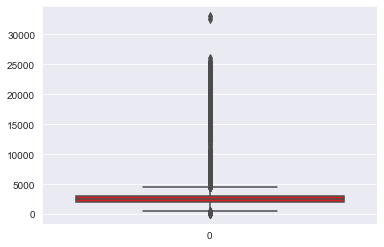

In [63]:
#Hacemos un boxplot para ver la distribución de la columna P x m2
sns.boxplot(data=dfCapi['price_usd_per_m2'], color = 'r');

In [64]:
dfCapi['price_usd_per_m2'][dfCapi['price_usd_per_m2']<=100] = np.NaN

<ipython-input-64-c09c13115e10>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfCapi['price_usd_per_m2'][dfCapi['price_usd_per_m2']<=100] = np.NaN


In [65]:
#como hay outliers calculamos el rango intercuartil para excluirlos en el análisis 
q1 = dfCapi['price_usd_per_m2'].quantile(0.25)
q2 = dfCapi['price_usd_per_m2'].quantile(0.5)
q3 = dfCapi['price_usd_per_m2'].quantile(0.75)
q4 = dfCapi['price_usd_per_m2'].quantile(1)

riq = q3-q1
lim_inf = q1-1.5*riq
lim_sup = q3+1.5*riq
print(lim_inf," ",lim_sup)


464.3848288621664   4588.035769349366


In [66]:
#Creo columna auxiliar para completar sin outiler ni nulos para preservar los valores originales 
dfCapi["price_m2_sin_out"] = dfCapi.price_usd_per_m2
dfCapi['price_m2_sin_out'][(dfCapi['price_m2_sin_out'] < lim_inf) | (dfCapi['price_m2_sin_out'] > lim_sup)] = np.NaN # reemplazos los outliers por nulls

#Filtro los datos sin outliers para trabajar con ellos
price_m2_sin_out = dfCapi['price_usd_per_m2'][(dfCapi['price_usd_per_m2'] >= lim_inf) & ((dfCapi['price_usd_per_m2'] <= lim_sup))]
price_m2_sin_out

<ipython-input-66-a645baf22d79>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfCapi['price_m2_sin_out'][(dfCapi['price_m2_sin_out'] < lim_inf) | (dfCapi['price_m2_sin_out'] > lim_sup)] = np.NaN # reemplazos los outliers por nulls


0        1127.272727
1        1309.090909
3        3066.666667
4        3000.000000
5        2234.000000
            ...     
28069    3750.000000
28070    2611.464968
28071    2611.464968
28072    2858.695652
28073    1675.324675
Name: price_usd_per_m2, Length: 18486, dtype: float64

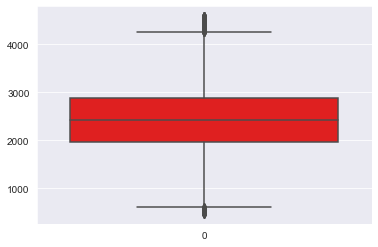

In [67]:
#chequeamos graf. con un boxplot de nuevo
sns.boxplot(data=price_m2_sin_out, color = 'r');

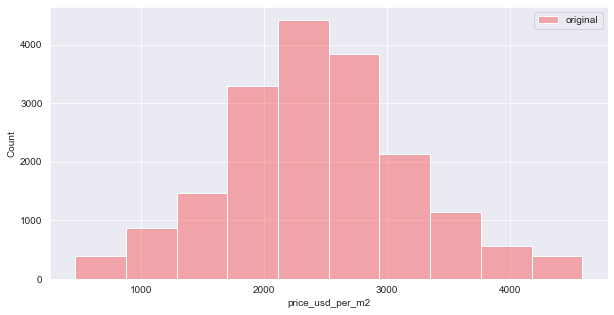

In [68]:
#histograma de la columna sin outliers y mayores a usd 100
fig = plt.figure(figsize=(10,5));ax=plt.axes()
sns.histplot(price_m2_sin_out, color = 'r',bins=10, alpha=0.3)
ax.legend(labels = ['original'])

In [69]:
#Observamos que en al nueva columna hay nulos originales mas los aplicados a los outliers
dfCapi['price_m2_sin_out'].isnull().sum()

9588

Reemplazo de valores nulos de campo price_usd_per_m2

In [70]:
#tenemos que ver como se completan los datos nulos. Proponemos asignar la media agrupada por tipo de propiedad y por barrio 
dfCapi_grouped = dfCapi.groupby(["place_name",'property_type'])['price_m2_sin_out']
price_usd_per_m2_por_tipo_prop = dfCapi_grouped.transform(lambda x : x.fillna(x.mean()))

In [71]:
#Analizamos media, mediana y moda de las dos columnas
print('La media original es:',round(dfCapi['price_usd_per_m2'].mean(),2))
print('La moda original es:', round(dfCapi['price_usd_per_m2'].mode()[0],2))
print('La mediana original es:',round (dfCapi['price_usd_per_m2'].median(),2))

print('La media completada por tipo de propiedad es:', round(price_usd_per_m2_por_tipo_prop.mean(), 2)) 
print('La moda completada por tipo de propiedad es:', round(price_usd_per_m2_por_tipo_prop.mode()[0],2))
print('La mediana completada por tipo de propiedad es:', round(price_usd_per_m2_por_tipo_prop.median(),2))

La media original es: 3019.02
La moda original es: 2500.0
La mediana original es: 2484.85
La media completada por tipo de propiedad es: 2458.54
La moda completada por tipo de propiedad es: 3017.34
La mediana completada por tipo de propiedad es: 2426.65


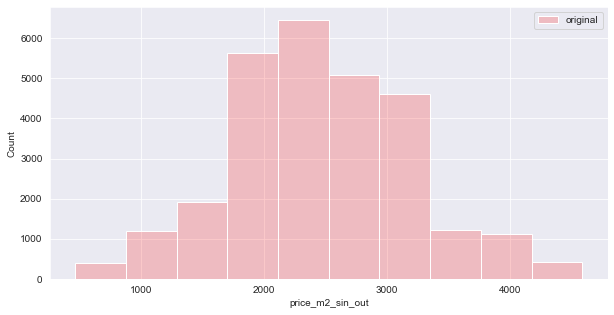

In [72]:
fig = plt.figure(figsize=(10,5));ax=plt.axes()

sns.histplot(price_usd_per_m2_por_tipo_prop, color = 'r',bins=10,alpha=0.2,)
#sns.histplot(price_usd_per_m2_por_tipo_prop[(price_usd_per_m2_por_tipo_prop < lim_sup) & (price_usd_per_m2_por_tipo_prop > 100)], color = 'g',bins=10,alpha=0.2)


ax.legend(labels=['original', 'per-type']);

In [73]:
#reemplazo valores
dfCapi['price_m2_sin_out'] = price_usd_per_m2_por_tipo_prop

In [74]:
dfCapi['price_m2_sin_out'].isnull().sum()

23

**- Rooms, price y superficie: eliminación de outliers**

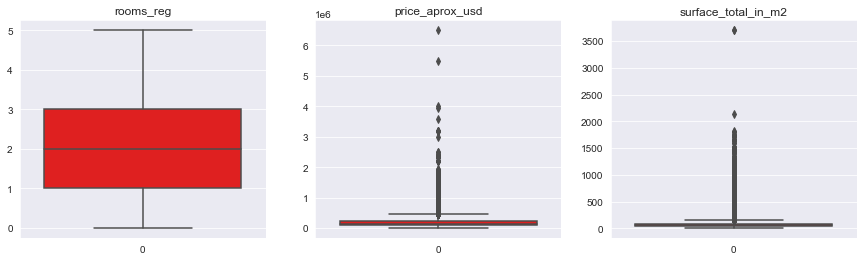

In [75]:
fig = plt.figure(figsize=(15,4))
plt.subplot(131)
plt.title('rooms_reg')
sns.boxplot(data=dfCapi['rooms_reg'], color = 'r');

plt.subplot(132)
plt.title('price_aprox_usd')
sns.boxplot(data=dfCapi['price_aprox_usd'], color = 'r');

plt.subplot(133)
plt.title('surface_total_in_m2')
sns.boxplot(data=dfCapi['surface_total_in_m2'], color = 'r');


In [76]:
#Eliminamos outliers de rooms

q1 = dfCapi['rooms_reg'].quantile(0.25)
q3 = dfCapi['rooms_reg'].quantile(0.75)

riq = q3-q1
lim_inf = q1-1.5*riq # -2
lim_sup = q3+1.5*riq # 6

dfCapi= dfCapi[(dfCapi.rooms_reg.isnull()) | (dfCapi['rooms_reg'] < lim_sup)]

In [77]:

q1 = dfCapi['price_aprox_usd'].quantile(0.25)
q3 = dfCapi['price_aprox_usd'].quantile(0.75)

riq = q3-q1
lim_sup = q3+1.5*riq # 6

In [78]:
#Eliminamos outliers de price_aprox_usd

q1 = dfCapi['price_aprox_usd'].quantile(0.25)
q3 = dfCapi['price_aprox_usd'].quantile(0.75)

riq = q3-q1
lim_inf = q1-1.5*riq # -2
lim_sup = q3+1.5*riq # 6

dfCapi= dfCapi[(dfCapi.price_aprox_usd.isnull()) | (dfCapi['price_aprox_usd'] < lim_sup)]

In [79]:
#Eliminamos outliers de surface_total_in_m2

q1 = dfCapi['surface_total_in_m2'].quantile(0.25)
q3 = dfCapi['surface_total_in_m2'].quantile(0.75)

riq = q3-q1
lim_inf = q1-1.5*riq # -2
lim_sup = q3+1.5*riq # 6

dfCapi= dfCapi[(dfCapi.surface_total_in_m2.isnull()) | (dfCapi['surface_total_in_m2'] < lim_sup)]

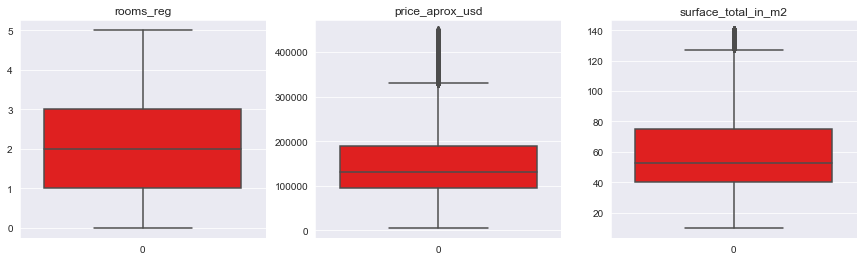

In [80]:
fig = plt.figure(figsize=(15,4))
plt.subplot(131)
plt.title('rooms_reg')
sns.boxplot(data=dfCapi['rooms_reg'], color = 'r');

plt.subplot(132)
plt.title('price_aprox_usd')
sns.boxplot(data=dfCapi['price_aprox_usd'], color = 'r');

plt.subplot(133)
plt.title('surface_total_in_m2')
sns.boxplot(data=dfCapi['surface_total_in_m2'], color = 'r');


In [81]:
dfCapi["cerca_lejos"] = dfCapi.apply(lambda x: 1 if x.distancia_subte < 400 else 0, axis=1)

### **2. Análisis descriptivo y relaciones entre variables**

**- Relación Barrio y precio en usd por m2**

Hacemos un mapa de calor con la media de price_usd_per_m2 sin outliers por barrio y comparamos con su versión con outliers 

In [82]:
#Volvemos a tirar el df agrupado con los promedios de las variables cuanti para usar despues en el mapa de calor 
dfCapi_grouped=dfCapi.groupby('place_name').mean()
dfCapi_grouped

,Unnamed: 0,Unnamed: 0.1,geonames_id,lat,lon,price,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,rooms_reg,price_m2_sin_out,distancia_subte,cerca_lejos
place_name,,,,,,,,,,,,,,,,,,,
Abasto,13280.950000,59012.250000,NaN,-34.603424,-58.411739,143944.350649,2.201536e+06,124771.816494,55.650794,51.726027,2216.008248,2724.828722,6.500000,2.466667,1486.565217,2.287671,2214.937803,207.343273,0.687500
Agronomía,10894.880000,48771.520000,3436487.0,-34.591886,-58.485309,137690.434783,2.429479e+06,137690.434783,57.157895,56.130435,2257.803667,2549.937271,6.000000,2.476190,3466.666667,2.480000,2257.803667,1040.380000,0.000000
Almagro,13303.954268,58785.709350,3436397.0,-34.607882,-58.421786,191514.716707,2.306807e+06,130738.024286,57.620939,60.152542,2264.488453,4203.834848,4.377953,2.351852,2230.338583,2.229044,2249.092843,330.997097,0.557927
Balvanera,13455.265378,59724.479789,6693228.0,-34.609652,-58.402640,129068.005576,2.090149e+06,118458.947509,62.988067,67.293561,1981.091493,2486.061741,6.072581,2.644562,2092.697531,2.551456,1966.196294,214.226614,0.826011
Barracas,11427.665635,50926.904025,3436134.0,-34.636875,-58.373823,147833.593548,2.493611e+06,141325.138226,68.530686,64.794521,2080.236964,2443.203075,14.666667,2.526882,2411.725490,2.470383,2032.632134,1116.044859,0.009288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
villa devoto,12129.500000,54661.500000,3433955.0,-34.619281,-58.518171,90000.000000,1.588005e+06,90000.000000,41.000000,NaN,2195.121951,NaN,NaN,1.000000,NaN,1.000000,2195.121951,4405.360000,0.000000
villa general mitre,17982.571429,78310.785714,3433955.0,-34.611130,-58.466698,307974.615385,2.902931e+06,164523.294615,53.000000,63.545455,1946.324664,8243.511050,NaN,1.000000,1593.888889,2.090909,1790.532993,1079.288571,0.000000
villa luro,17590.000000,75705.500000,3433955.0,-34.642476,-58.490923,125000.000000,2.205562e+06,125000.000000,129.000000,99.000000,968.992248,1262.626263,NaN,NaN,NaN,3.500000,968.992248,2468.090000,0.000000


In [83]:
# Ahora volvemos a hacer el match entre barrios y dfCapi1_grouped. Vamos a armar dos columnas:
# 1) usdm2 que va a tener la media de price_usd_per_m2 por barrio
# 2) usdm2_sin_out lo mismo pero con la columna sin outliers
#Si no printea ningun barrio es porque matcheo todo

In [84]:
usdm2=[]
for i,x in barrios.iterrows():
    try:
        j=dfCapi_grouped.index.get_loc(x.barrio)
        usdm2.append(dfCapi_grouped.iloc[j].price_usd_per_m2) # le appedeamos el price usd por m2 de dfCapi_grouped promedio a pm2. Si no lo encuentra le pone 0
    except:
        # printeo los que no encuentra
        print(x.barrio)
        usdm2.append(0)

chacarita
villa del parque
parque patricios
mataderos
villa lugano
san telmo
saavedra
coghlan
villa urquiza
colegiales
agronomía
villa ortuzar
villa riachuelo
villa soldati
villa pueyrredón
liniers
puerto madero
boca


In [85]:
usdm2_sin_out=[]
for i,x in barrios.iterrows():
    try:
        j=dfCapi_grouped.index.get_loc(x.barrio)
        usdm2_sin_out.append(dfCapi_grouped.iloc[j].price_m2_sin_out) # le appedeamos el price usd por m2 de dfCapi_grouped promedio a pm2. Si no lo encuentra le pone 0
    except:
        # printeo los que no encuentra
        (x.barrio)
        usdm2_sin_out.append(0)

In [86]:
# Sumamos estas listas al df de barrios para hacer los mapas de calor 
barrios['price_usd_per_m2']=usdm2
barrios['price_usd_per_m2_sin_out']=usdm2_sin_out
barrios.head(5)

,Unnamed: 0,Unnamed: 0.1,WKT,barrio,COMUNA,PERIMETRO,AREA,WKT_shapely,price_usd_per_m2,price_usd_per_m2_sin_out
0,0,0,"POLYGON ((-58.4528200492791 -34.5959886570639,...",chacarita,15.0,7725.695228,3.118101e+06,"POLYGON ((-58.4528200492791 -34.5959886570639,...",0.000000,0.000000
1,1,1,"POLYGON ((-58.4655768128541 -34.5965577078058,...",paternal,15.0,7087.513295,2.229829e+06,"POLYGON ((-58.4655768128541 -34.5965577078058,...",NaN,NaN
2,2,2,"POLYGON ((-58.4237529813037 -34.5978273383243,...",villa crespo,15.0,8132.699348,3.613584e+06,"POLYGON ((-58.4237529813037 -34.5978273383243,...",2040.691193,2040.691193
3,3,3,"POLYGON ((-58.4946097568899 -34.6148652395239,...",villa del parque,11.0,7705.389797,3.399596e+06,"POLYGON ((-58.4946097568899 -34.6148652395239,...",0.000000,0.000000
4,4,4,"POLYGON ((-58.4128700313089 -34.6141162515854,...",almagro,5.0,8537.901368,4.050752e+06,"POLYGON ((-58.4128700313089 -34.6141162515854,...",2464.788050,2464.788050


In [87]:
# Armamos un geojson para armar los mapas
shapes=[ dict({'geometry': wkt.loads(x.WKT) , 'id' : x.barrio }) for i,x in barrios.iterrows()] 
# ahora armo el diccionario GeoJSON con esta lista:

gd2=dict({'type': 'FeatureCollection' ,'features' : shapes })

In [88]:
#Mapa sin outliers: Puerto Madero es el barrio con mayor precio, seguido por Recoleta, Palermo, Belgrano y Nuñez. El precio cae si nos movemos al sur y al oeste
# fig = px.choropleth_mapbox(barrios,geojson=gd2, locations='barrio', color='price_usd_per_m2_sin_out' ,mapbox_style="carto-positron",center = {"lat": -34.6, "lon": -58.35},   
#                            opacity=0.5, zoom= 10, height=500 ,  color_continuous_scale="aggrnyl")
# fig.show()

In [89]:
#Mapa calor price_usd_per_m2 (sin sacar outliers): nos confirma que la eliminación de outliers estuvo bien dado que en este caso Boedo y San Cristobal tienen una media de precio en usd por metro cuadrado mayor a barrios como Puerto Madero, que no es creible
# fig = px.choropleth_mapbox(barrios,geojson=gd2, locations='barrio', color='price_usd_per_m2' ,mapbox_style="carto-positron",center = {"lat": -34.6, "lon": -58.35},   
#                            opacity=0.5, zoom= 10, height=500 ,  color_continuous_scale="aggrnyl")
# fig.show()

- **Boxplot de precio por m2 por barrio**

In [90]:
# sns.set_style('darkgrid')
# plt.figure(figsize=(100,100))
# sns.boxplot(data=dfCapi, x="place_name", y="price_m2_sin_out")

# plt.xlabel("place_name"); plt.ylabel("price_usd_per_m2_sin_out");plt.title("Box Plot")
# plt.show()


- **Relación por tipo de propiedad, precio y superficie**

In [91]:
# SACAR OUTLIERS DE SUPERFICE

In [92]:
# g = sns.FacetGrid(dfCapi, col="property_type")
# g.map(sns.scatterplot, "surface_total_in_m2", "price_m2_sin_out")
# g.fig.set_size_inches(25, 10)
# g.set_axis_labels('Surface in M2', "Price per M2 in USD")
# plt.show()

- **Distribución de precio en usd por m2**

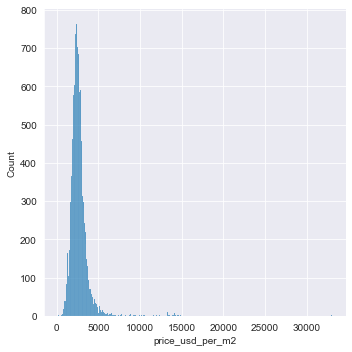

In [93]:
sns.displot(dfCapi['price_usd_per_m2']);

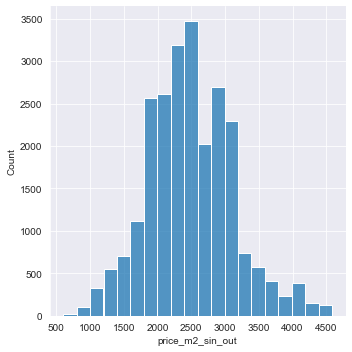

In [94]:
sns.displot(dfCapi['price_m2_sin_out'], bins=20);

- **Boxplot de precio por m2 por tipo de propiedad**

Los departamentos en promedio son más caros que las casas. En general las casas se dan más en barrios más baratos 

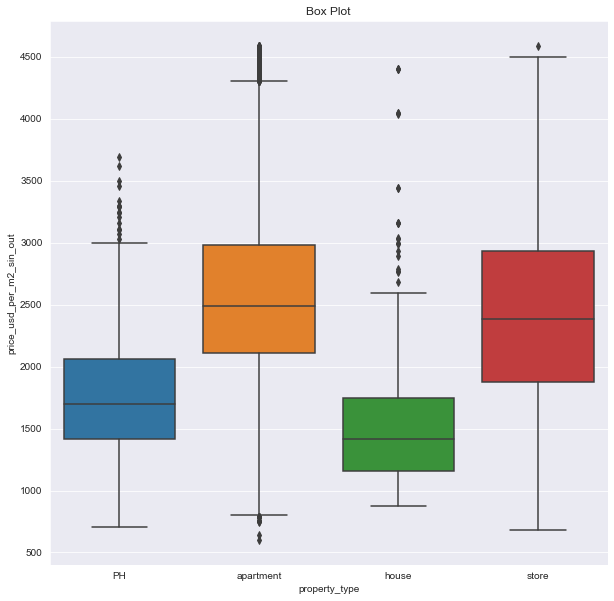

In [95]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,10))
sns.boxplot(data=dfCapi, x="property_type", y="price_m2_sin_out")

plt.xlabel("property_type"); plt.ylabel("price_usd_per_m2_sin_out");plt.title("Box Plot")
plt.show()

In [96]:
dfCapi.loc[:,["property_type","price_m2_sin_out"]].groupby("property_type").agg(["mean","median", "skew"])

price_m2_sin_out                       
                          mean       median      skew
property_type                                        
PH                 1773.563198  1701.030928  0.687441
apartment          2544.800238  2484.848485  0.467606
house              1561.374051  1416.381873  1.912278
store              2416.443486  2383.803028  0.152015

### **3. Creación de nuevos campos**

- Amenities

In [97]:
#Convertimos la columna description en una lista
description_list = list(set(dfCapi['description']))

In [98]:
# Armamos una lista de keywords que nos interesa encontrar en la columna description de cada propiedad
amenities_list = ['parrilla', 'hidromasaje', 'jacuzzi','terraza','cochera', 'solarium', 'baulera', 'balcón', 'patio','patios','sum','salón de usos múltiples','seguridad' ,'mármol', 'gimnasio', 'gym','lavadero','losa radiante','vigilancia','laundry','luminoso','apto profesional',"pileta","piscina"]

In [99]:
#Regex para separar con pipes cada keyword
ame = r'\b(?:{})\b'.format('|'.join(map(re.escape, amenities_list)))

In [100]:
#Ponemos en minuscula las descripciones
dfCapi['description']=dfCapi.description.str.lower()
dfCapi_amenities=dfCapi

In [101]:
#nos fijamos en que descripcion hay algun valor de la lista de amenities
df_amenities = dfCapi_amenities.loc[dfCapi_amenities['description'].str.contains(ame)].reset_index()

In [102]:

df_amenities['aux_split']=df_amenities.description.str.split(' ')

In [103]:
df_amenities.head()

,index,Unnamed: 0,Unnamed: 0.1,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,...,properati_url,description,title,image_thumbnail,rooms_reg,price_m2_sin_out,geometry,distancia_subte,cerca_lejos,aux_split
0,0,0,0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,...,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 ambientes tipo casa planta baja por pasillo,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...,2.0,1127.272727,POINT (-58.5088387 -34.6618237),4728.39,0,"[2, ambientes, tipo, casa, planta, baja, por, ..."
1,1,1,2,sell,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,...,http://www.properati.com.ar/15bod_venta_depart...,2 ambientes 3er piso lateral living comedor am...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,https://thumbs4.properati.com/5/SXKr34F_IwG3W_...,2.0,1309.090909,POINT (-58.5229825 -34.6522615),6073.15,0,"[2, ambientes, 3er, piso, lateral, living, com..."
2,2,2,3,sell,PH,Liniers,|Argentina|Capital Federal|Liniers|,Argentina,Capital Federal,3431333.0,...,http://www.properati.com.ar/15boh_venta_ph_lin...,ph 3 ambientes con patio. hay 3 deptos en lote...,PH 3 amb. cfte. reciclado,https://thumbs4.properati.com/3/DgIfX-85Mog5SP...,3.0,1487.571343,POINT (-58.5164244 -34.6477969),5305.63,0,"[ph, 3, ambientes, con, patio., hay, 3, deptos..."
3,3,3,7,sell,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Argentina,Capital Federal,3436077.0,...,http://www.properati.com.ar/15bot_venta_depart...,excelente monoambiente a estrenar amplio super...,JOSE HERNANDEZ 1400 MONOAMBIENTE ESTRENAR CAT...,https://thumbs4.properati.com/1/IHxARynlr8sPEW...,1.0,3066.666667,POINT (-58.443362 -34.5598729),609.74,0,"[excelente, monoambiente, a, estrenar, amplio,..."
4,4,4,8,sell,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Argentina,Capital Federal,3436077.0,...,http://www.properati.com.ar/15bou_venta_depart...,excelente dos ambientes estrenar amplio super...,"JOSE HERNANDEZ 1400 DOS AMBIENTES ESTRENAR ,...",https://thumbs4.properati.com/2/J3zOjgaFHrkvnv...,2.0,3000.000000,POINT (-58.443362 -34.5598729),609.74,0,"[excelente, dos, ambientes, , estrenar, amplio..."


In [104]:
ame_name = []
aux_split = []
events = []
for i in range(len(df_amenities['aux_split'])):
    for j in range(len(df_amenities['aux_split'][i])):
        if df_amenities['aux_split'][i][j] in amenities_list:
            ame_name.append(df_amenities['aux_split'][i][j])
            aux_split.append((df_amenities['index'][i]))
            events.append(1)

In [105]:
aux_ame = pd.DataFrame(
    {'aux_split': aux_split,
     'Amenities': ame_name,
     'events':events
    })

In [106]:
aux_ame.head(20)

,aux_split,Amenities,events
0,0,patio,1
1,3,luminoso,1
2,3,pileta,1
3,3,laundry,1
4,4,luminoso,1
5,4,pileta,1
6,4,laundry,1
7,5,terraza,1
8,5,piscina,1
9,6,piscina,1


In [107]:
amenities= pd.pivot_table(aux_ame, index=['aux_split'], columns= ['Amenities'])

In [108]:
amenities.columns = amenities.columns.get_level_values(1)

In [109]:
amenities.size

336042

In [110]:
dfCapi['index_original']=dfCapi.index

In [111]:
dfCapi.size

802626

In [112]:

dfCapi= dfCapi.merge(amenities, left_on='index_original', right_on='aux_split', how='left').fillna(0)


In [113]:
df_amenities.drop_duplicates(subset=["index"], inplace=True)

In [114]:
df_amenities

,index,Unnamed: 0,Unnamed: 0.1,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,...,properati_url,description,title,image_thumbnail,rooms_reg,price_m2_sin_out,geometry,distancia_subte,cerca_lejos,aux_split
0,0,0,0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,...,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 ambientes tipo casa planta baja por pasillo,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...,2.0,1127.272727,POINT (-58.5088387 -34.6618237),4728.39,0,"[2, ambientes, tipo, casa, planta, baja, por, ..."
1,1,1,2,sell,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,...,http://www.properati.com.ar/15bod_venta_depart...,2 ambientes 3er piso lateral living comedor am...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,https://thumbs4.properati.com/5/SXKr34F_IwG3W_...,2.0,1309.090909,POINT (-58.5229825 -34.6522615),6073.15,0,"[2, ambientes, 3er, piso, lateral, living, com..."
2,2,2,3,sell,PH,Liniers,|Argentina|Capital Federal|Liniers|,Argentina,Capital Federal,3431333.0,...,http://www.properati.com.ar/15boh_venta_ph_lin...,ph 3 ambientes con patio. hay 3 deptos en lote...,PH 3 amb. cfte. reciclado,https://thumbs4.properati.com/3/DgIfX-85Mog5SP...,3.0,1487.571343,POINT (-58.5164244 -34.6477969),5305.63,0,"[ph, 3, ambientes, con, patio., hay, 3, deptos..."
3,3,3,7,sell,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Argentina,Capital Federal,3436077.0,...,http://www.properati.com.ar/15bot_venta_depart...,excelente monoambiente a estrenar amplio super...,JOSE HERNANDEZ 1400 MONOAMBIENTE ESTRENAR CAT...,https://thumbs4.properati.com/1/IHxARynlr8sPEW...,1.0,3066.666667,POINT (-58.443362 -34.5598729),609.74,0,"[excelente, monoambiente, a, estrenar, amplio,..."
4,4,4,8,sell,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Argentina,Capital Federal,3436077.0,...,http://www.properati.com.ar/15bou_venta_depart...,excelente dos ambientes estrenar amplio super...,"JOSE HERNANDEZ 1400 DOS AMBIENTES ESTRENAR ,...",https://thumbs4.properati.com/2/J3zOjgaFHrkvnv...,2.0,3000.000000,POINT (-58.443362 -34.5598729),609.74,0,"[excelente, dos, ambientes, , estrenar, amplio..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19670,28067,28067,121153,sell,apartment,Barrio Norte,|Argentina|Capital Federal|Barrio Norte|,Argentina,Capital Federal,3436109.0,...,http://www.properati.com.ar/1cj5g_venta_depart...,excelente departamento con terraza propia y pa...,EXCELENTE DEPARTAMENTO DE 3 AMBIENTES CON TERR...,https://thumbs4.properati.com/0/xIo-Keo_1sE6zO...,NaN,1813.186813,POINT (-58.4025191971 -34.5992135511),141.07,1,"[excelente, departamento, con, terraza, propia..."
19671,28068,28068,121157,sell,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Argentina,Capital Federal,3436077.0,...,http://www.properati.com.ar/1cj5q_venta_depart...,torre de 16º pisos ubicado en pleno centro com...,Departamento - Belgrano C,https://thumbs4.properati.com/3/jy7Bo02JdmAK4J...,NaN,3368.421053,POINT (nan nan),NaN,0,"[torre, de, 16º, pisos, ubicado, en, pleno, ce..."
19672,28069,28069,121158,sell,apartment,Recoleta,|Argentina|Capital Federal|Recoleta|,Argentina,Capital Federal,3429595.0,...,http://www.properati.com.ar/1cj5s_venta_depart...,excelente ubicación - avenida pueyrredon y las...,Departamento - Recoleta,https://thumbs4.properati.com/1/O847ZBAPkkdt0a...,1.0,3750.000000,POINT (-58.3973722534 -34.587425443),17.58,1,"[excelente, ubicación, -, avenida, pueyrredon,..."
19673,28072,28072,121217,sell,apartment,Villa Urquiza,|Argentina|Capital Federal|Villa Urquiza|,Argentina,Capital Federal,3433775.0,...,http://www.properati.com.ar/1cja7_venta_depart...,venta departamento ambiente divisible a estren...,VENTA DEPARTAMENTO AMBIENTE DIVISIBLE A ESTREN...,https://thumbs4.properati.com/9/YAe_-2gRVykADP...,1.0,2858.695652,POINT (-58.4755963355 -

In [115]:
dfCapi.size

1313388

In [116]:
dfCapi['index_original']

0            0
1            1
2            2
3            3
4            4
         ...  
24317    28067
24318    28068
24319    28069
24320    28072
24321    28073
Name: index_original, Length: 24322, dtype: int64

In [117]:
dfCapi["suma_amenities"] = dfCapi.loc[:,['balcón', 'baulera', 'cochera', 'gimnasio', 'gym',
       'hidromasaje', 'jacuzzi', 'laundry', 'lavadero', 'luminoso', 'mármol',
       'parrilla', 'patio', 'patios', 'seguridad', 'solarium', 'sum',
       'terraza', 'vigilancia', "pileta","piscina"]].sum(axis=1)

In [118]:
dfCapi

,Unnamed: 0,Unnamed: 0.1,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,...,patio,patios,pileta,piscina,seguridad,solarium,sum,terraza,vigilancia,suma_amenities
0,0,0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,2,sell,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6522615,-58.5229825",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,3,sell,PH,Liniers,|Argentina|Capital Federal|Liniers|,Argentina,Capital Federal,3431333.0,"-34.6477969,-58.5164244",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,7,sell,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Argentina,Capital Federal,3436077.0,"-34.5598729,-58.443362",...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
4,4,8,sell,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Argentina,Capital Federal,3436077.0,"-34.5598729,-58.443362",...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24317,28067,121153,sell,apartment,Barrio Norte,|Argentina|Capital Federal|Barrio Norte|,Argentina,Capital Federal,3436109.0,"-34.5992135511,-58.4025191971",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0
24318,28068,121157,sell,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Argentina,Capital Federal,3436077.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
24319,28069,121158,sell,apartment,Recoleta,|Argentina|Capital Federal|Recoleta|,Argentina,Capital Federal,3429595.0,"-34.587425443,-58.3973722534",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
24320,28072,121217,sell,apartment,Villa Urquiza,|Argentina|Capital Federal|Villa Urquiza|,Argentina,Capital Federal,3433775.0,"-34.5706388726,-58.4755963355",...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,4.0


In [119]:
dfCapi.to_csv("final.csv")

In [220]:
corr = dfCapi.loc[:,["price_aprox_usd","surface_total_in_m2","surface_covered_in_m2","price_aprox_usd_per_m2","floor","expenses","suma_amenities"]].corr()

<ipython-input-226-4f421c3512b8>:2: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



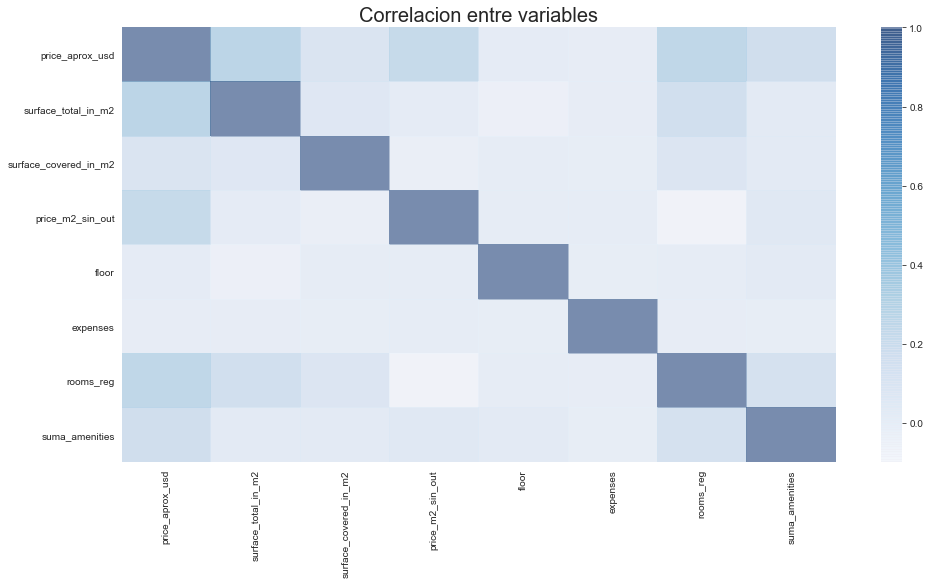

In [226]:
fig, ax = plt.subplots(figsize=(16,8))       
cor.values[[np.arange(6)]*2] = 0
ax = plt.axes()
sns.heatmap(corr,cmap='Blues', alpha=0.5,ax=ax);
ax.set_title('Correlacion entre variables', fontsize=20)

plt.show();

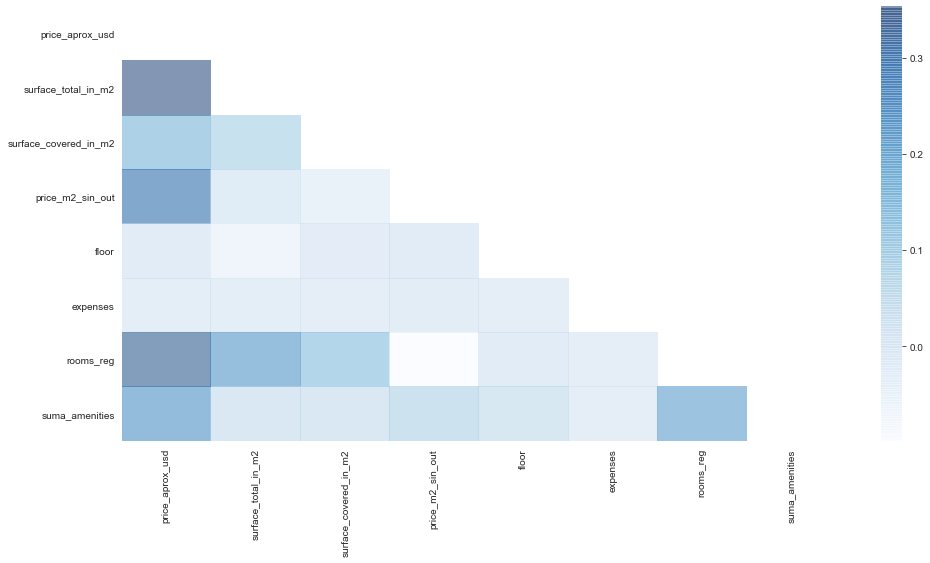

In [227]:
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 8))
    ax = sns.heatmap(corr, cmap = "Blues", alpha=0.5, mask=mask)